# The Discrete Fourier Transform

*This Jupyter notebook is part of a [collection of notebooks](../index.ipynb) in the bachelors module Signals and Systems, Comunications Engineering, Universität Rostock. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).*

## Fast Convolution

The linear convolution of signals is a basic building block in many practical applications. The straightforward convolution of two finite-length signals $x[k]$ and $h[k]$ has considerable numerical complexity. This has led to the development of various algorithms that realize the convolution with lower complexity. The basic concept of the *fast convolution* is to exploit the [convolution theorem](theorems.ipynb#Convolution-Theorem) of the discrete Fourier transform (DFT). This theorem states that the periodic convolution of two signals is equal to a scalar multiplication of their spectra. The scalar multiplication has considerably less numerical operations that the convolution. The transformation of the signals can be performed efficiently by the [fast Fourier transform](fast_fourier_transform.ipynb) (FFT). 

Since the scalar multiplication of the spectra realizes a periodic convolution, special care has to be taken to realize a linear convolution in the spectral domain. The equivalence between linear and periodic convolution is discussed in the following.

### Equivalence of Linear and Periodic Convolution

The [linear convolution](../discrete_systems/linear_convolution.ipynb#Finite-Length-Signals) of a causal signal $x_L[k]$ of length $L$ with a causal signal $h_N[k]$ of length $N$ reads

\begin{equation}
y[k] = x_L[k] * h_N[k] = \sum_{\kappa = 0}^{L-1} x_L[\kappa] \; h_N[k - \kappa] = \sum_{\kappa = 0}^{N-1} h_N[\kappa] \; x_L[k - \kappa]
\end{equation}

The resulting signal $y[k]$ is of finite length $M = N+L-1$. Without loss of generality it is assumed in the following that $N \leq L$. The computation of $y[k]$ for $k=0,1, \dots, M-1$ requires $M \cdot N$ multiplications and $M \cdot (N-1)$ additions. The computational complexity of the convolution is consequently [on the order of](https://en.wikipedia.org/wiki/Big_O_notation) $\mathcal{O}(M \cdot N)$.

The [periodic (or circular/cyclic) convolution](https://en.wikipedia.org/wiki/Circular_convolution) of two signals $x_L[k]$ and $h_N[k]$ is defined as

\begin{equation}
x_L[k] \circledast_P h_N[k] = \sum_{\kappa=0}^{P-1} \tilde{x}_P[k - \kappa] \; \tilde{h}_P[\kappa]
\end{equation}

where $\circledast_P$ denotes the periodic convolution with period $P$. The periodic summations $\tilde{x}_P[k]$ of $x[k]$ and $\tilde{h}_P[k]$ of $h[k]$ with period $P$ are defined as

\begin{align}
\tilde{x}_P[k] &= \sum_{\nu = -\infty}^{\infty} x_L[\nu \cdot P + k] \\
\tilde{h}_P[k] &= \sum_{\nu = -\infty}^{\infty} h_N[\nu \cdot P + k]
\end{align}

The result of the circular convolution has a period of $P$.


To compute the linear convolution by a periodic convolution, one has to take care that the result of the linear convolution fits into one period of the periodic convolution. Hence, the periodicity has to be chosen as $P \geq M$ where $M = N+L-1$. This can be achieved by zero-padding of $x_L[k]$ to the total length $M$ resulting in the signal $x_M[k]$ of length $M$ which is defined as

\begin{equation}
x_M[k] = \begin{cases} 
x_L[k] & \text{for } 0 \leq k < L \\
0 & \text{for } L \leq k < M
\end{cases}
\end{equation}

and similar for $h_N[k]$ resulting in the zero-padded signal $h_M[k]$ which is defined as

\begin{equation}
h_M[k] = \begin{cases} 
h_N[k] & \text{for } 0 \leq k < N \\
0 & \text{for } N \leq k < M
\end{cases}
\end{equation}

Using these signals, the linear and periodic convolution are equivalent for the first $M$ samples $k = 0,1,\dots, M-1$

\begin{equation}
x_L[k] * h_N[k] = x_M[k] \circledast_M h_M[k]
\end{equation}

#### Example

The following example computes the linear, periodic and linear by periodic convolution of two signals $x[k] = \text{rect}_L[k]$ and $h[k] = \text{rect}_N[k]$.

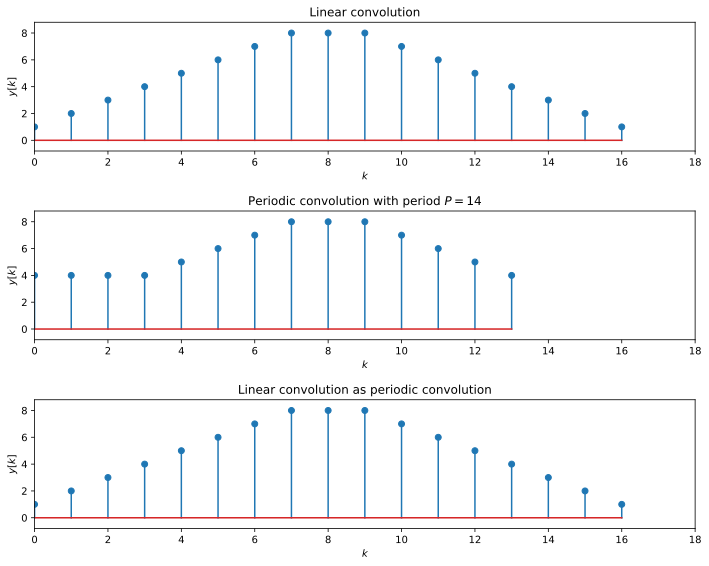

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tools import cconv
%matplotlib inline

L = 8  # length of signal x[k]
N = 10  # length of signal h[k]
P = 14 # periodicity of periodic convolution

# generate signals
x = np.ones(L)
h = np.ones(N)

# linear convolution
y1 = np.convolve(x, h, 'full')
# periodic convolution
y2 = cconv(x, h, int(P))
# linear convolution via periodic convolution
xp = np.append(x, np.zeros(N-1))
hp = np.append(h, np.zeros(L-1))
y3 = cconv(xp, hp, L+N-1)

# plot results
def plot_signal(x):
    plt.stem(x)
    plt.xlabel('$k$')
    plt.ylabel('$y[k]$')
    plt.xlim([0, N+L])
    plt.gca().margins(y=0.1)

plt.figure(figsize = (10, 8))
plt.subplot(3,1,1)
plot_signal(y1)
plt.title('Linear convolution')

plt.subplot(3,1,2)
plot_signal(y2)
plt.title('Periodic convolution with period $P=%d$'%P)

plt.subplot(3,1,3)
plot_signal(y3)
plt.title('Linear convolution as periodic convolution')
plt.tight_layout()

**Exercise**

* Change the lengths `L`, `N` and `P` and check how the results for the different convolutions change.

### The Fast Convolution Algorithm

Using the above derived equality of the linear and periodic convolution one can express the linear convolution $y[k] = x_L[k] * h_N[k]$ by the DFT as

$$ y[k] = \text{IDFT}_M \{ \; \text{DFT}_M\{ x_M[k] \} \cdot \text{DFT}_M\{ h_M[k] \} \; \} $$

The resulting algorithm is composed of the following steps

1. Zero-padding of the two input signals $x_L[k]$ and $h_N[k]$ to at least a total length of $M \geq N+L-1$

2. Computation of the DFTs $X[\mu]$ and $H[\mu]$ using a FFT of length $M$

3. Multiplication of the spectra $Y[\mu] = X[\mu] \cdot H[\mu]$

4. Inverse DFT of $Y[\mu]$ using an inverse FFT of length $M$

The algorithm requires two DFTs of length $M$, $M$ complex multiplications and one IDFT of length $M$. On first sight this does not seem to be an improvement, since one DFT/IDFT requires $M^2$ complex multiplications and $M \cdot (M-1)$ complex additions. The overall numerical complexity is hence in the order of $\mathcal{O}(M^2)$. The DFT can be realized efficiently by the [fast Fourier transformation](fast_fourier_transform.ipynb) (FFT), which lowers the number of numerical operations for each DFT/IDFT significantly. The actual gain depends on the particular implementation of the FFT. Many FFTs are most efficient for lengths which are a power of two. It therefore can make sense, in terms of the number of numerical operations, to choose $M$ as a power of two instead of the shortest possible length $N+L-1$. In this case, the numerical complexity of the radix-2 algorithm is on the order of $\mathcal{O}(M \log_2 M)$.

The introduced algorithm is known as *fast convolution* due to its computational efficiency when realized by the FFT. For real valued signals $x[k] \in \mathbb{R}$ and $h[k] \in \mathbb{R}$ the number of numerical operations can be reduced further by using a real valued FFT.

#### Example

The implementation of the fast convolution algorithm is straightforward. In the following example the fast convolution of two real-valued signals $x[k] = \text{rect}_L[k]$ and $h[k] = \text{rect}_N[k]$ is shown. The real valued FFT/IFFT is consequently used. Most implementations of the FFT include the zero-padding to a given length $M$, e.g as in `numpy` by `numpy.fft.rfft(x, M)`.

Text(0, 0.5, 'y[k]')

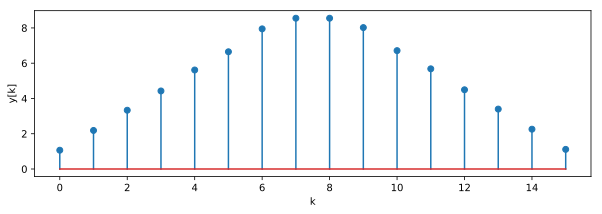

In [2]:
L = 8  # length of signal x[k]
N = 10  # length of signal h[k]

# generate signals
x = np.ones(L)
h = np.ones(N)

# fast convolution
M = N+L-1
y = np.fft.irfft(np.fft.rfft(x, M)*np.fft.rfft(h, M))

# show result
plt.figure(figsize=(10, 3))
plt.stem(y)
plt.xlabel('k')
plt.ylabel('y[k]')

### Benchmark

It was already argued that the numerical complexity of the fast convolution is considerably lower due to the usage of the FFT. As measure, the gain in terms of execution time with respect to the linear convolution is evaluated in the following. Both algorithms are executed for the convolution of two real-valued signals $x_L[k]$ and $h_N[k]$ of length $L=N=2^n$ for $n \in \mathbb{N}$. The length of the FFTs/IFFT was chosen as $M=2^{n+1}$. The results depend heavily on the implementation of the FFT and the hardware used. Note that the execution of the following cell may take some time.

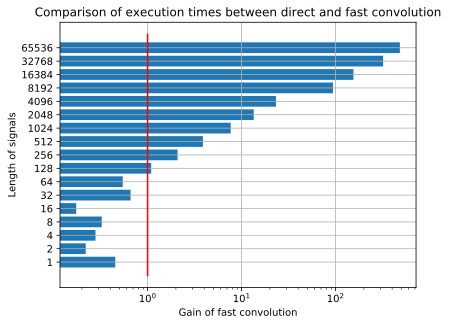

In [3]:
import timeit

n = np.arange(17)  # lengths = 2**n to evaluate
reps = 100  # number of repetitions for timeit

gain = np.zeros(len(n))
for N in n:
    length = 2**N
    # setup environment for timeit
    tsetup = 'import numpy as np; from numpy.fft import rfft, irfft; \
            x=np.random.randn(%d); h=np.random.randn(%d)' % (length, length)
    # direct convolution
    tc = timeit.timeit('np.convolve(x, x, "full")', setup=tsetup, number=reps)
    # fast convolution
    tf = timeit.timeit('irfft(rfft(x, %d) * rfft(h, %d))' % (2*length, 2*length), setup=tsetup, number=reps)
    # speedup by using the fast convolution
    gain[N] = tc/tf

# show the results
plt.barh(n, gain, log=True)
plt.plot([1, 1], [-1, n[-1]+1], 'r-')
plt.yticks(n, 2**n)
plt.xlabel('Gain of fast convolution')
plt.ylabel('Length of signals')
plt.title('Comparison of execution times between direct and fast convolution')
plt.grid()

**Exercise**

* For which lengths is the fast convolution faster than the linear convolution? 
* Why is it slower below a given signal length?
* Is the trend of the gain as expected from above considerations?

**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Sascha Spors, Continuous- and Discrete-Time Signals and Systems - Theory and Computational Examples*.